# 3-SAT Solver using Grover's Algorithm

The problem instance used here is:

(x_1 OR x_2 OR NOT x_3) AND (NOT x_1 OR NOT x_2 OR NOT x_3) AND (x_1 OR NOT x_2 OR x_3)

A satisfying assignment for this instance is x_1=1, x_2=0, x_3=1 (or the bitstring '101').




## Imports



In [22]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCMT
from qiskit.visualization import plot_histogram
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator

# Function Definitions




In [23]:

def create_3sat_oracle(n_variables, clauses):
    """
    Creates the quantum oracle for a given 3-SAT instance.

    The oracle marks the quantum states that correspond to satisfying assignments.
    It works by:
    1. For each clause, using a multi-controlled Toffoli (MCX) gate to check if the clause is NOT satisfied.
       The result is stored in an ancilla qubit for that clause.
    2. Using another MCX gate to check if ALL clause ancillas are 0 (meaning all clauses ARE satisfied).
       The result of this check flips a final output ancilla qubit.
    3. Uncomputing the clause ancilla results to clean up the workspace.

    Args:
        n_variables (int): The number of boolean variables in the problem.
        clauses (list[tuple]): A list of clauses. Each clause is a tuple of 3 integers.
                               A positive integer i means variable x_i.
                               A negative integer -i means NOT x_i.

    Returns:
        QuantumCircuit: The quantum circuit implementing the oracle.
    """
    n_clauses = len(clauses)
    var_qubits = range(n_variables)
    clause_qubits = range(n_variables, n_variables + n_clauses)
    output_qubit = n_variables + n_clauses
    total_qubits = n_variables + n_clauses + 1

    oracle_circuit = QuantumCircuit(total_qubits, name="Oracle")

    # --- Step 1: Compute if each clause is satisfied ---
    for i, clause in enumerate(clauses):
        control_qubits = []
        for literal in clause:
            if literal > 0:
                oracle_circuit.x(abs(literal) - 1)
            control_qubits.append(abs(literal) - 1)

        oracle_circuit.mcx(control_qubits, clause_qubits[i])

        for literal in clause:
            if literal > 0:
                oracle_circuit.x(abs(literal) - 1)
        oracle_circuit.barrier()

    # --- Step 2: Flip the output qubit if all clauses are satisfied ---
    oracle_circuit.x(clause_qubits)
    oracle_circuit.mcx(list(clause_qubits), output_qubit)
    oracle_circuit.x(clause_qubits)
    oracle_circuit.barrier()

    # --- Step 3: Uncompute the clause satisfaction to clean the ancillas ---
    for i, clause in enumerate(reversed(clauses)):
        clause_idx = n_clauses - 1 - i
        control_qubits = []
        for literal in clause:
            if literal > 0:
                oracle_circuit.x(abs(literal) - 1)
            control_qubits.append(abs(literal) - 1)

        oracle_circuit.mcx(control_qubits, clause_qubits[clause_idx])

        for literal in clause:
            if literal > 0:
                oracle_circuit.x(abs(literal) - 1)
        oracle_circuit.barrier()

    return oracle_circuit

def create_diffuser(n_variables):
    """
    Creates the diffuser (amplitude amplification) circuit for Grover's algorithm.
    """
    qc = QuantumCircuit(n_variables, name="Diffuser")
    qc.h(range(n_variables))
    qc.x(range(n_variables))
    qc.h(n_variables - 1)
    qc.mcx(list(range(n_variables - 1)), n_variables - 1)
    qc.h(n_variables - 1)
    qc.x(range(n_variables))
    qc.h(range(n_variables))
    return qc

def verify_solution(solution_bits, clauses):
    """Checks if a given bitstring solution satisfies all clauses."""
    for clause in clauses:
        clause_satisfied = False
        for literal in clause:
            var_index = abs(literal) - 1
            # Ensure the solution_bits string is long enough
            if var_index >= len(solution_bits):
                return False
            var_value = int(solution_bits[var_index])
            if (literal > 0 and var_value == 1) or (literal < 0 and var_value == 0):
                clause_satisfied = True
                break
        if not clause_satisfied:
            return False
    return True

# Problem Definition




In [24]:
# Define the 3-SAT problem instance
n_vars = 3
clauses = [(1, 2, -3), (-1, -2, -3), (1, -2, 3)]

# Determine the number of Grover iterations
n_solutions = 1 # Assuming we are looking for at least one solution
grover_iterations = int(np.floor(np.pi / 4 * np.sqrt(2**n_vars / n_solutions)))
print(f"Number of variables: {n_vars}")
print(f"Clauses: {clauses}")
print(f"Optimal number of Grover iterations (assuming {n_solutions} solution(s)): {grover_iterations}\n")

Number of variables: 3
Clauses: [(1, 2, -3), (-1, -2, -3), (1, -2, 3)]
Optimal number of Grover iterations (assuming 1 solution(s)): 2



# Circuit Building




In [25]:
# Build the Oracle and Diffuser circuits
oracle = create_3sat_oracle(n_vars, clauses)
diffuser = create_diffuser(n_vars)

# Assemble the full Grover circuit
var_qubits = range(n_vars)
n_clauses = len(clauses)
total_qubits = n_vars + n_clauses + 1

grover_circuit = QuantumCircuit(total_qubits, n_vars)
grover_circuit.h(var_qubits)
grover_circuit.x(n_vars + n_clauses)
grover_circuit.h(n_vars + n_clauses)
grover_circuit.barrier()

for _ in range(grover_iterations):
    grover_circuit.append(oracle, range(total_qubits))
    grover_circuit.barrier()
    grover_circuit.append(diffuser, var_qubits)
    grover_circuit.barrier()

grover_circuit.measure(var_qubits, var_qubits)

# Execution




In [26]:
sampler = Sampler()
job = sampler.run(grover_circuit, shots=1024)
result = job.result()

# Draw the circuit using Matplotlib


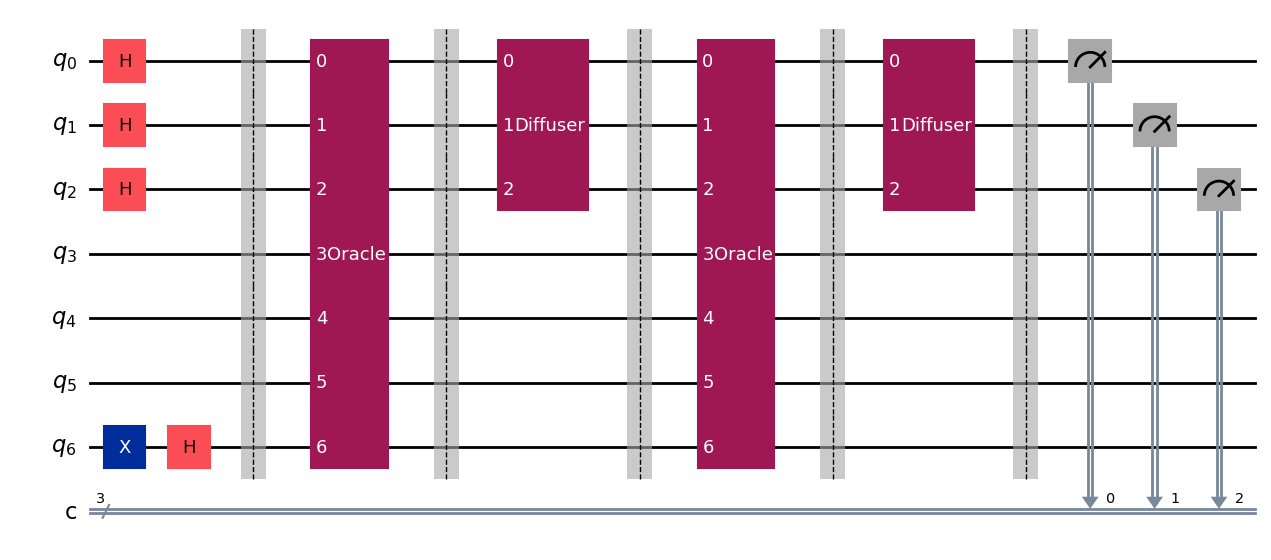

In [27]:
grover_circuit.draw(output="mpl")

# Result Processing



In [28]:
# The result object contains quasi-probabilities.
# We get the distribution for the first (and only) circuit.
quasi_distribution = result.quasi_dists[0]

# Convert the integer keys to binary strings
counts = {f'{k:0{n_vars}b}': v * 1024 for k, v in quasi_distribution.items()}

# Find the most frequent measurement result
most_likely_solution_binary = max(counts, key=counts.get)

# The result is already in the correct order (q_n-1 ... q_1 q_0)
# We reverse it to match our variable order (x1, x2, x3)
solution_candidate = most_likely_solution_binary[::-1]

print(f"\n--- Results ---")
print(f"Top measurement result (x3, x2, x1): {most_likely_solution_binary}")
print(f"Proposed solution (x1, x2, x3): {solution_candidate}")

# Verify the solution
is_correct = verify_solution(solution_candidate, clauses)
if is_correct:
    print("\nVerification successful: The solution satisfies all clauses.")
else:
    print("\nVerification failed: The solution does not satisfy all clauses.")


--- Results ---
Top measurement result (x3, x2, x1): 110
Proposed solution (x1, x2, x3): 011

Verification successful: The solution satisfies all clauses.


# Plotting






Plotting measurement outcomes...


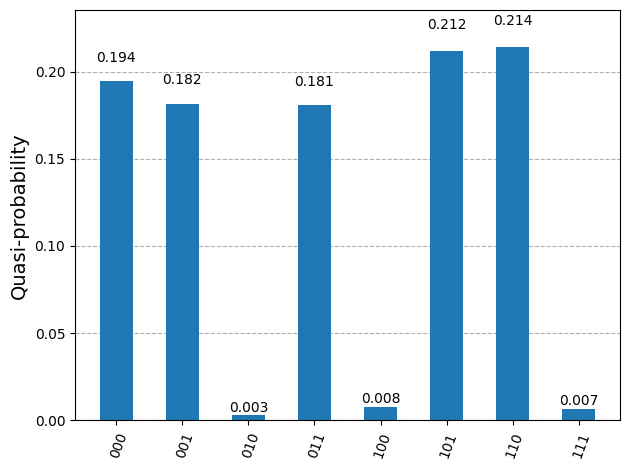

In [29]:
# Display the measurement histogram
print("\nPlotting measurement outcomes...")
plot_histogram(counts)